In [91]:
import numpy as np
from collections import defaultdict


import matplotlib.pyplot as plt
from skimage import feature, morphology,transform, io, color


In [92]:
plt.rcParams['text.color'] = 'w'
plt.rcParams['xtick.color'] = 'w'
plt.rcParams['ytick.color'] = 'w'
plt.rcParams['axes.labelcolor'] = 'w'

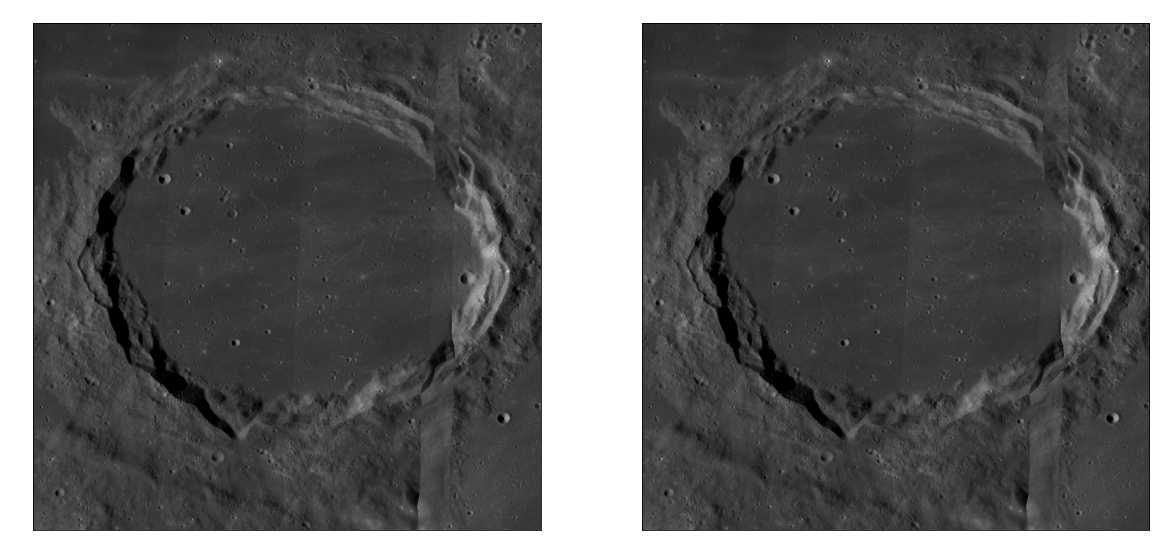

In [93]:
moon = io.imread('img/moon.tif')
moon = color.rgb2gray(moon)
crop = moon[8300:9300, 15800:16800]

plt.figure(figsize= (20, 15))

plt.subplot(121)
plt.title('Moon image')
plt.imshow(crop, cmap="gray")

plt.subplot(122)
plt.title('Detection area')
plt.imshow(crop, cmap="gray")



In [94]:
class Detector:

    @staticmethod
    def imageProcess(image, struct_el1, struct_el2, struct_el3, canny_sigma, radius, height, width):
        '''Function for image processing
            Crop exploring area of image
            Segment exploring image'''
        cropped_peak = image[np.abs(radius-height):radius+height, np.abs(radius-width):radius+width]

        plt.figure(figsize=(15, 10))
        plt.imshow(cropped_peak, cmap="gray")

        height = np.size(cropped_peak, 0)
        width = np.size(cropped_peak, 1)

        segmented_image = np.zeros((height, width))

        for y in range(height):
            for x in range(width):
                if int(cropped_peak[y][x]) <= 1:
                    segmented_image[y][x] = 1

        segmented_image = morphology.dilation(segmented_image, morphology.disk(struct_el3))
        segmented_image = morphology.opening(segmented_image, morphology.disk(struct_el2))
        segmented_image = morphology.dilation(segmented_image, morphology.disk(struct_el1))

        segmented_image = feature.canny(segmented_image, sigma=canny_sigma)

        plt.figure(figsize=(15, 10))
        plt.title("Border of peaks")
        plt.imshow(segmented_image, cmap="gray")

        return segmented_image, cropped_peak

    @classmethod
    def __drawBigPeak(cls, image, circles, title):
        '''Draw Circle area of Big Crater'''
        cnt_holles, Radius, Width, Height, peak_parameters = 0, 0, 0, 0, (0, 0, 0)
        fig, ax = plt.subplots(figsize= (15, 10))
        ax.imshow(image, cmap="gray")

        for circle in circles:
            ax.add_artist(plt.Circle((circle[1] * 5, circle[0] * 5), circle[2] * 5, fill=False, color= 'orange'))

            Radius, Width, Height = circle[2] * 5, circle[0] * 5, circle[1] * 5
            peak_parameters = (circle[0] * 5, circle[1] * 5, circle[2] * 5)
            parameters = peak_parameters

            cnt_holles += 1
            if cnt_holles == 1:
                break

        plt.title(title)
        plt.show()

        return Radius, Width, Height, parameters

    @classmethod
    def __drawSmallPeaks(cls, circles, res_image, image, title):
        '''Draw Circle area of small craters'''
        height = np.size(image, 0)

        fig, ax = plt.subplots(figsize= (15, 10))
        ax.imshow(res_image, cmap="gray")

        cnt_holes = 0
        peak_parameters = []

        dim = height // 4

        for circle in circles:
            if dim < circle[0] < height - dim and dim < circle[1] < height - dim:
                ax.add_artist(plt.Circle((circle[1], circle[0]), circle[2], fill=False, color= 'blue'))
                peak_parameters.append((circle[0], circle[1], circle[2]))
                cnt_holes += 1
            if cnt_holes == 7:
                break
        plt.title(title)
        plt.show()

        return cnt_holes, peak_parameters

    @classmethod
    def defineAccumulator(cls, image, X, Y, peaks):
        '''Return defined accumulator matrix '''
        accumulator = defaultdict(np.int)

        for x in range(Y):
            for y in range(X):
                if image[x][y]:
                    for radius, xCentroid, yCentroid in peaks:
                        coords = [(x - xCentroid), (y - yCentroid)]
                        accumulator[(coords[0], coords[1], radius)] += 1
        return accumulator

    @classmethod
    def seekPeak(cls, image, res_image, radius, iterations, threshold):
        '''Seek Big Crater in exploring area'''
        height_res = np.size(res_image, 0)
        width_res = np.size(res_image, 1)
        peaks = []

        for iter in range(iterations):
            peaks.append((radius, int(radius * np.cos(2 * np.pi * iter / iterations)), int(radius * np.sin(2 * np.pi * iter / iterations))))

        accumulator_matrix = cls.defineAccumulator(res_image, width_res, height_res, peaks)
        circles = []

        for k, v in sorted(accumulator_matrix.items(), key=lambda i: -i[1]):
            x, y, radii = k
            if v / iterations >= threshold and all((x - a) ** 2 + (y - b) ** 2 > R ** 2 for a, b, R in circles):
                circles.append((x, y, radii))

        return cls.__drawBigPeak(image, circles, "Big Crater")

    @classmethod
    def seekSmallPeaks(cls, res_image, peak_image, min_radii, max_radii, iterations, threshold):
        '''Seek small craters in Big Crater using hough circle transformation'''
        height_res = np.size(peak_image, 0)
        width_res = np.size(peak_image, 1)
        peaks = []

        for r in range(min_radii, max_radii + 1):
            for iter in range(iterations):
                peaks.append((r, int(r * np.cos(2 * np.pi * iter / iterations)), int(r * np.sin(2 * np.pi * iter / iterations))))

        accumulator_matrix = cls.defineAccumulator(peak_image, width_res, height_res, peaks)
        circles = []

        for keys, v in sorted(accumulator_matrix.items(), key=lambda i: -i[1]):
            x, y, radii = keys
            if v / iterations >= threshold and all((x - a)**2 + (y - b)**2 > R**2 for a, b, R in circles):
                circles.append((x, y, radii))

        return cls.__drawSmallPeaks(circles, res_image, peak_image, "Hough Transformation Result")

In [95]:
def print_parameters(X, Y, Peak_Parameter, cnt_craters):
    '''Print result paramaters of defined craters e.g coords and radius'''
    print(f"Coords of big Crater: {X + Peak_Parameter[1]}, {Y + Peak_Parameter[0]}", "\n")
    print(f"Crater radius: {Peak_Parameter[2]}")

    for count in range(cnt_craters):
        print(f'Crater №{count + 1}, Small choords of holles: {X + (Peak_Parameter[0] - Peak_Parameter[1]) + peaks_parameters[count][1]}, {Y + (Peak_Parameter[0] - Peak_Parameter[2]) + peaks_parameters[count][0]}, '
              f'Radius: {peaks_parameters[count][2]}')

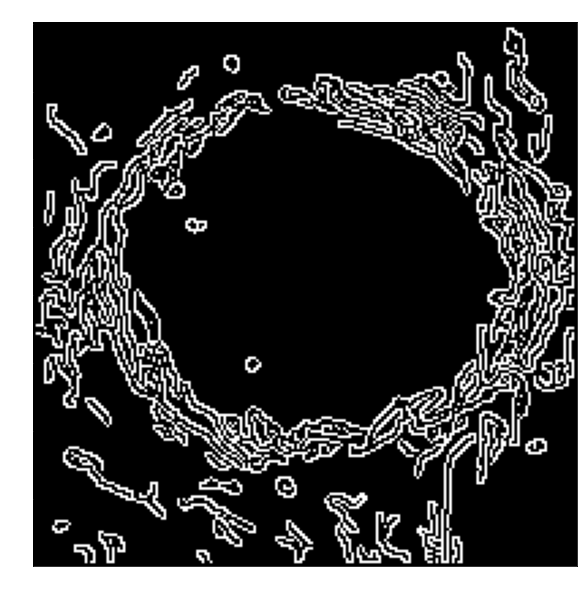

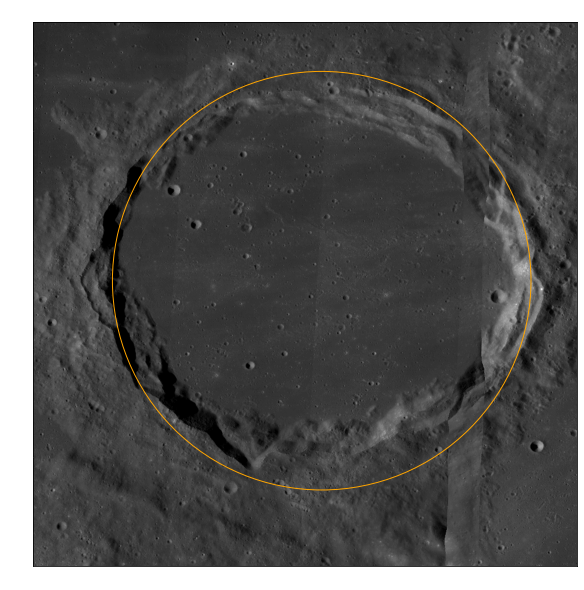

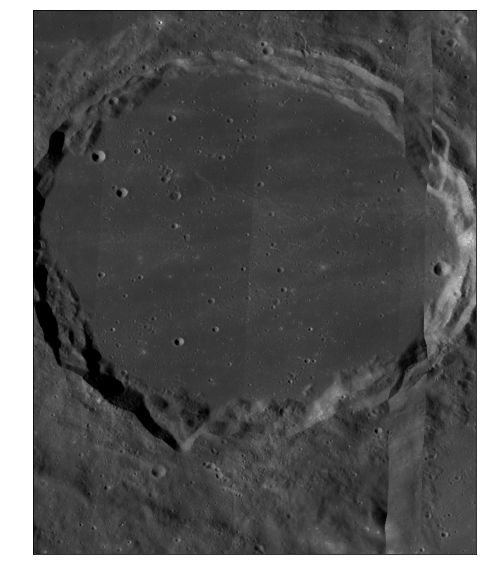

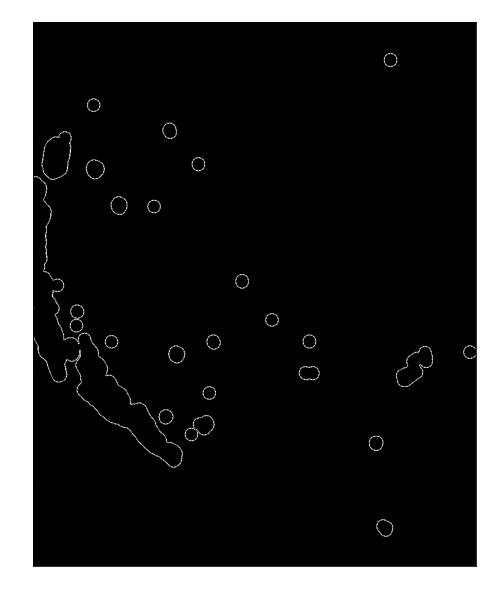

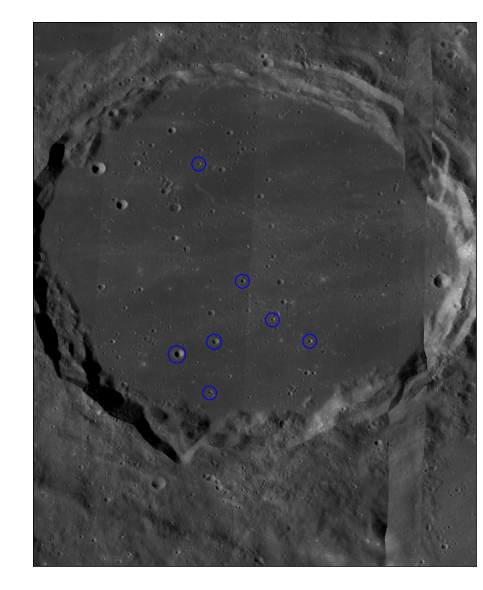

Coords of big Crater: 530, 475 

Crater radius: 385
Crater №1, Small choords of holles: 360, 607, Radius: 12
Crater №2, Small choords of holles: 251, 734, Radius: 12
Crater №3, Small choords of holles: 232, 336, Radius: 12
Crater №4, Small choords of holles: 425, 644, Radius: 12
Crater №5, Small choords of holles: 308, 540, Radius: 12
Crater №6, Small choords of holles: 194, 667, Radius: 15
Crater №7, Small choords of holles: 259, 645, Radius: 13


In [96]:
start_row, end_row, step = 8300, 9300, 1000
start_col, end_col = 15800, 16800

detected_craters, Peak_Parameter, peaks_parameters, X, Y = 0, (0, 0, 0), list(), 0, 0
crater_cnt = 7

for y in range(start_row, end_row, step):
    for x in range(start_col, end_col, step):

            crop = moon[y:y+step, x:x+step]

            resize = transform.resize(crop, (200, 200))
            canny_crop = feature.canny(resize)
            canny_crop = feature.canny(canny_crop)

            plt.figure(figsize= (15, 10))
            plt.title('Image borders')
            plt.imshow(canny_crop, cmap="gray")

            Width, Height, Radius, Peak_Parameter = Detector.seekPeak(crop, canny_crop, 77, 120, 0.4)

            segmented_img, cropped_img = Detector.imageProcess(crop, 1, 1, 10, 0.1, Radius, Height, Width)

            dc, peaks_parameters = Detector.seekSmallPeaks(cropped_img, segmented_img, 10, 20, 120, 0.4)


            detected_craters = dc
            if detected_craters == crater_cnt:
                break

    if detected_craters == crater_cnt:
        break

print_parameters(X, Y, Peak_Parameter, crater_cnt)




